In [1]:
%pylab inline

from __future__ import division

import numpy as np 
import os

# Shapely related imports 
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from shapely.ops      import cascaded_union
from shapely          import wkb 

from descartes        import PolygonPatch

# Astropy related imports 
from astropy.io    import fits
from astropy.table import Table

# Matplotlib default settings
from matplotlib import pyplot
from matplotlib import rc, font_manager
rcdef = plt.rcParams.copy()
rc('axes', linewidth=2)
pylab.rcParams['figure.figsize'] = 14, 10

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define a few colors 
BLUE = '#6699cc'
GRAY = '#999999'

In [3]:
## Open and read the catalog file 
def readFitsCat(catFile, hdu=1): 
    
    hduList = fits.open(catFile)
    catData = hduList[hdu].data 
    
    return catData 

# Example: Old G-band 
catG1 = 'ssp341_wide_G_corners.fits' 
patchG1 = readFitsCat(catG1)

In [4]:
def getPolyList(catData):
    polyList = map(lambda x: MultiPoint(((x.field('raLL'), x.field('decLL')),
                                     (x.field('raUL'), x.field('decUL')), 
                                     (x.field('raUR'), x.field('decUR')), 
                                     (x.field('raLR'), x.field('decLR')))).convex_hull, catData) 
    return polyList 

# Get the polygon shape for each image
polyList = getPolyList(patchG1)

In [8]:
def getPolyUnion(polyList):
    polyUnion = cascaded_union(polyList)
    polyArea  = polyUnion.area
    
    return polyUnion, polyArea 

# Get the combined poly region 
polyUnion, polyArea = getPolyUnion(polyList)
print "The total area of the poly region is %7.2f square degree" % polyArea

The total area of the poly region is   87.76 square degree


In [11]:
polyUnion.geom_type

'MultiPolygon'

In [7]:
def getMinMaxRaDec(catData): 
    minRa  = np.min([catData.field('raLL').min(), catData.field('raLR').min(), 
                    catData.field('raUL').min(), catData.field('raUR').min()])
    minDec = np.min([catData.field('decLL').min(), catData.field('decLR').min(), 
                    catData.field('decUL').min(), catData.field('decUR').min()])
    maxRa  = np.max([catData.field('raLL').max(), catData.field('raLR').max(), 
                    catData.field('raUL').max(), catData.field('raUR').max()])
    maxDec = np.max([catData.field('decLL').max(), catData.field('decLR').max(), 
                    catData.field('decUL').max(), catData.field('decUR').max()])
    
    return minRa, maxRa, minDec, maxDec

# Get the min, max of the Ra, Dec 
minRa, maxRa, minDec, maxDec = getMinMaxRaDec(patchG1)
print minRa, maxRa, minDec, maxDec

30.3951 337.136 -7.35218 3.07134


(-7.552177143096924, 3.2713410377502443)

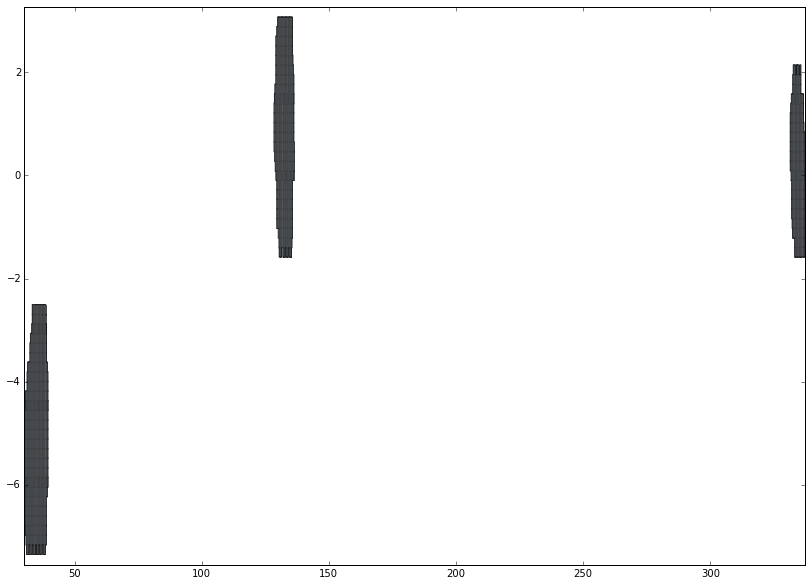

In [8]:
# Plot the polygons
fig = pyplot.figure(1, dpi=100)
ax = fig.add_subplot(111)

for reg in polyList: 
    regShow = PolygonPatch(reg, fc=BLUE, alpha=0.6, zorder=1)
    ax.add_patch(regShow)

if len(polyUnion.geoms) is 1: 
    unionShow = PolygonPatch(polyUnion, fc=GRAY, alpha=0.3, zorder=2)
    ax.add_patch(unionShow)
else: 
    for part in polyUnion.geoms: 
        partShow = PolygonPatch(part, fc=GRAY, alpha=0.4, zorder=2)
        ax.add_patch(partShow)

polyBounds = polyUnion.bounds
raRange  = [(polyBounds[0]-0.2), (polyBounds[2]+0.2)]
decRange = [(polyBounds[1]-0.2), (polyBounds[3]+0.2)]

ax.set_xlim(*raRange)
ax.set_ylim(*decRange)

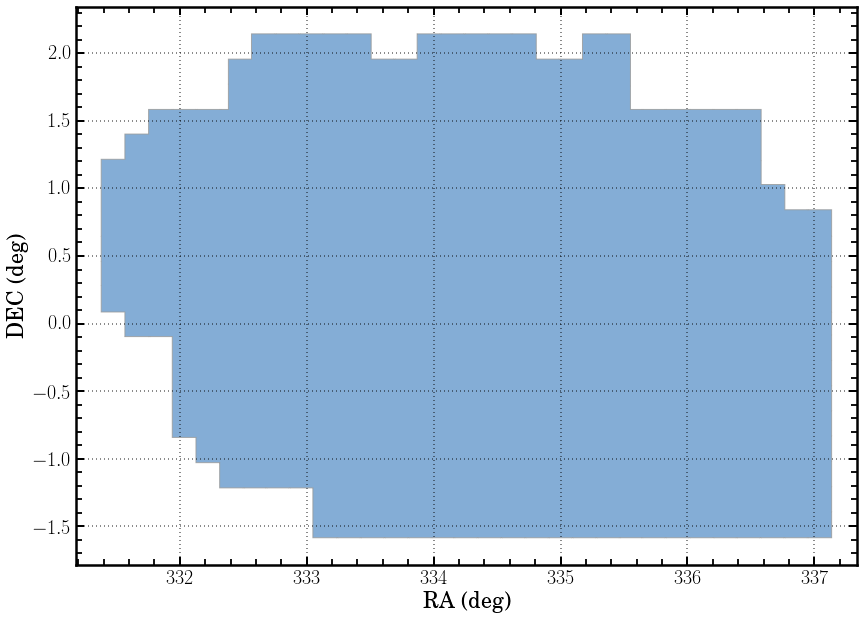

In [44]:
def plotPolyPart(poly, index): 
    
    # Plot the polygons
    fig = pyplot.figure(1, dpi=100)
    ax = fig.add_subplot(111)

    polyParts = poly.geoms
    partShow = PolygonPatch(polyParts[index], fc=BLUE, ec=GRAY, 
                            alpha=0.8, zorder=1)
    ax.add_patch(partShow)

    polyBounds = polyParts[index].bounds
    raRange  = [(polyBounds[0]-0.2), (polyBounds[2]+0.2)]
    decRange = [(polyBounds[1]-0.2), (polyBounds[3]+0.2)]

    ax.set_xlim(*raRange)
    ax.set_ylim(*decRange)
   
    #plt.rc('text', usetex=True)
    ax.set_xlabel(r'RA\ (deg)',  fontsize=22, fontweight='bold')
    ax.set_ylabel(r'DEC\ (deg)', fontsize=22, fontweight='bold')
    
    fontsize = 16
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        
    ax.minorticks_on()
    plt.tick_params(which='major', width=2.0, length=8.0, labelsize=20)      
    plt.tick_params(which='minor', width=1.8, length=6.0)      

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.5)
        
    ax.grid(alpha=0.6, color='k', linewidth=1.5)

    
# Only plot a part of the union 
plotPolyPart(polyUnion, 2)

In [61]:
def unionBreakDown(unionPoly): 
    nUnionPart = len(unionPoly.geoms)
    if nUnionPart is 1: 
        return unionPoly, nUnionPart
    else: 
        unionParts = map(lambda x: x, unionPoly.geoms)
        return unionParts, nUnionPart

# Break the multi-part polygon down to separated regions 
unionParts = unionBreakDown(polyUnion)

In [40]:
def isRaDecInside(poly, ra, dec): 
    
    point = Point((ra, dec)) 
    isInside = point.within(poly)
    
    return isInside 

# See whether certain coordinate 
ra1, dec1 = 35.0, -5.0 
ra2, dec2 = 45.0, 5.0 
isRaDecInside(polyUnion, ra2, dec2)

False

In [124]:
# Examples on Multiple Catalogs 

catG = 'ssp341_wide_G_corners.fits' 
catR = 'ssp341_wide_R_corners.fits' 
catI = 'ssp341_wide_I_corners.fits' 

patchG = readFitsCat(catG)
patchR = readFitsCat(catR)
patchI = readFitsCat(catI)

listG = getPolyList(patchG)
listR = getPolyList(patchR)
listI = getPolyList(patchI)

unionG, areaG = getPolyUnion(listG)
unionR, areaR = getPolyUnion(listR)
unionI, areaI = getPolyUnion(listI)

partsG, nPartG = unionBreakDown(unionG)
partsR, nPartR = unionBreakDown(unionR)
partsI, nPartI = unionBreakDown(unionI)

(-7.552177143096924, -2.119822072982788)

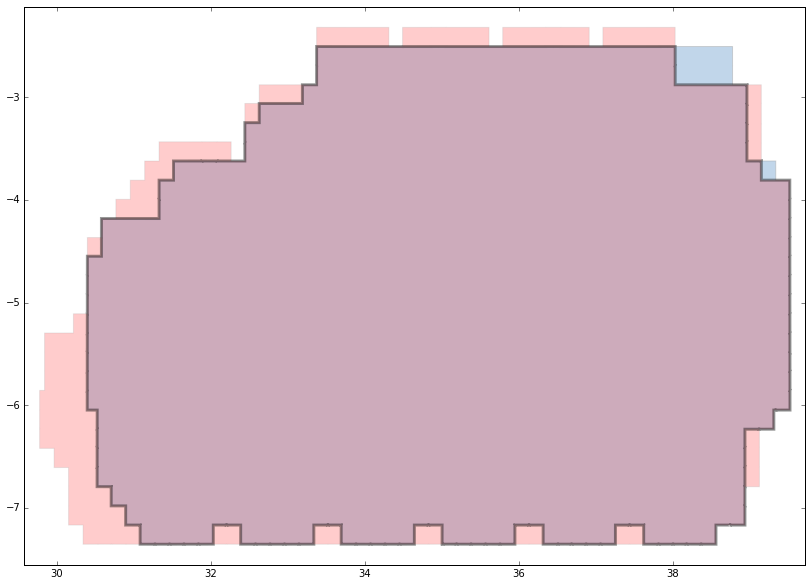

In [123]:
# The intersection of two polygons 
polyCommon   = partsI[0].intersection(partsG[0])
boundsCommon = partsI[0].union(partsG[0]).bounds

# Plot the polygons
fig = pyplot.figure(1, dpi=100)
ax = fig.add_subplot(111)

poly1 = PolygonPatch(partsG[0], fc=BLUE, ec=GRAY, alpha=0.4, zorder=1)
poly2 = PolygonPatch(partsI[0], fc='r',  ec=GRAY, alpha=0.2, zorder=2)
poly3 = PolygonPatch(polyCommon, fc='none', ec='k', alpha=0.4, zorder=3, 
                    linewidth=3)

ax.add_patch(poly1)
ax.add_patch(poly2)
ax.add_patch(poly3)

raRange  = [(boundsCommon[0]-0.2), (boundsCommon[2]+0.2)]
decRange = [(boundsCommon[1]-0.2), (boundsCommon[3]+0.2)]

ax.set_xlim(*raRange)
ax.set_ylim(*decRange)

(-7.552177143096924, -2.119822072982788)

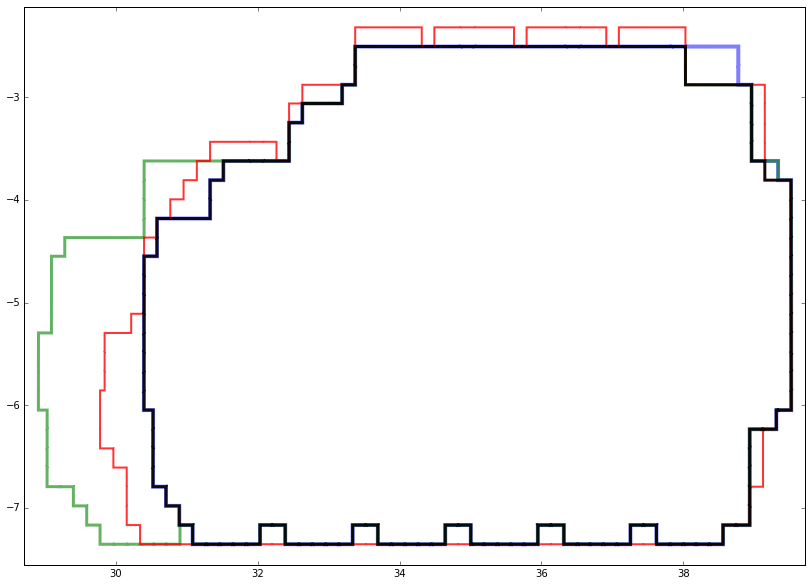

In [140]:
polyMulti = [partsG[0], partsR[0], partsI[0]]
nPoly = len(polyMulti) 

# Multiple intersections TODO: Don't know if there is better way to do this?
if nPoly > 2: 
    interMulti = polyMulti[0].intersection(polyMulti[1])
    for pp in polyMulti[2:]: 
        interMulti = interMulti.intersection(pp) 

boundsMulti = cascaded_union(polyMulti).bounds

# Plot the polygons
fig = pyplot.figure(1, dpi=100)
ax = fig.add_subplot(111)

poly1 = PolygonPatch(partsG[0], fc='none', ec='b', alpha=0.5, zorder=1, 
                    linewidth=4)
poly2 = PolygonPatch(partsR[0], fc='none', ec='g', alpha=0.6, zorder=2,
                    linewidth=3)
poly3 = PolygonPatch(partsI[0], fc='none', ec='r', alpha=0.8, zorder=3,
                    linewidth=2)

poly4 = PolygonPatch(interMulti, fc='none', ec='k', alpha=0.9, zorder=4, 
                    linewidth=3)

ax.add_patch(poly1)
ax.add_patch(poly2)
ax.add_patch(poly3)
ax.add_patch(poly4)

raRange  = [(boundsMulti[0]-0.2), (boundsMulti[2]+0.2)]
decRange = [(boundsMulti[1]-0.2), (boundsMulti[3]+0.2)]

ax.set_xlim(*raRange)
ax.set_ylim(*decRange)

In [ ]:
def polySaveWkb(poly, wkbName):
    
    polyWkb = wkb.dumps(poly)
    
    wkbFile = open(wkbName, 'w')
    wkbFile.write(polyWkb.encode('hex'))
    wkbFile.close()

def polyReadWkb(wkbName, load=True):  
    
    wkbFile = open(wkbName, 'r')
    polyWkb = wkbFile.read().decode('hex') 
    wkbFile.close() 
    
    if load is True: 
        return wkb.loads(polyWkb)
    else: 
        return polyWkb

def catSummarySave(catFile): 
    
    # Define the name of the output wkb file 
    catPrefix = os.path.splitext(catFile)[0]
    
    # Check the cat file 
    if not os.path.isfile(catFile): 
        raise Exception('Can not find the input catlog: %s' % catFile) 
    # Read in the data
    catData = readFitsCat(catFile)
    
    # Get the list of polygons 
    polyList = getPolyList(catData)

    # Get the Union of all polygons and its total area 
    polyUnion, areaUnion = getPolyUnion(polyList)
    # Save a region file 
    wkbUnion = polySaveWkb(polyUnion, catPrefix + '.wkb')

    # Break the Union into separated regions if necessary 
    polyParts, nParts = unionBreakDown(polyUnion)
    if nParts > 1: 
        for ii in range(nParts): 
            polySaveWkb(polyParts[ii], catPrefix + '_' + str(ii+1).strip() + '.wkb')
    
    return polyList, polyUnion

In [141]:
# Batch-mode 
import fnmatch 

location = '.' 
pattern  = 'ssp*_corners.fits'

for fileName in os.listdir(location):
    if fnmatch.fnmatch(fileName, pattern):
        print ('## ' + fileName) 
        catSummarySave(fileName) 

## ssp341_wide_G_corners.fits
## ssp341_wide_I_corners.fits
## ssp341_wide_R_corners.fits
## ssp341_wide_Y_corners.fits
## ssp341_wide_Z_corners.fits
## ssp361_wide_G_corners.fits
## ssp361_wide_I_corners.fits
## ssp361_wide_R_corners.fits
## ssp361_wide_Y_corners.fits
## ssp361_wide_Z_corners.fits


In [154]:
def polyMultiCommon(polyMulti): 
    
    nPoly = len(polyMulti) 
    boundsMulti = cascaded_union(polyMulti).bounds
    
    # Multiple intersections TODO: Don't know if there is better way to do this?
    if nPoly > 2: 
        interMulti = polyMulti[0].intersection(polyMulti[1])
        for pp in polyMulti[2:]: 
            interMulti = interMulti.intersection(pp) 
    elif nPoly == 2: 
        interMulti = polyMulti[0].intersection(polyMulti[1])
    else:
        print("WARNING: only one polygon found!")
        interMulti = polyMulti[0]
        
    return interMulti, boundsMulti

In [184]:
# Save the multi-bands common regions 
hscFilters = 'grizy'

ssp341Poly = map(lambda x: polyReadWkb('ssp341_wide_' + x.upper() + '_corners.wkb'), hscFilters)
ssp341Inter, ssp341Bounds = polyMultiCommon(ssp341Poly)
polySaveWkb(ssp341Inter, 'ssp341_wide_multibands.wkb')

ssp361Poly = map(lambda x: polyReadWkb('ssp361_wide_' + x.upper() + '_corners.wkb'), hscFilters)
ssp361Inter, ssp361Bounds = polyMultiCommon(ssp361Poly)
polySaveWkb(ssp361Inter, 'ssp361_wide_multibands.wkb')

In [185]:
def wkbListMatch(wkbFile, raList, decList): 
    
    if not os.path.isfile(wkbFile):
        raise Exception('Can not find the .wkb file: %s') % wkbFile
    else: 
        polyWkb = polyReadWkb(wkbFile)
        matches = np.array(map(lambda x,y : isRaDecInside(polyWkb, x, y), raList, decList))
        return matches 

# Batch-mode Ra, Dec match based on certain .wkb file 
rr = np.array([35.0, 100.0])
dd = np.array([-5.0, 6.0])
ww = 'ssp341_wide_multibands.wkb'
mm = wkbListMatch(ww, rr, dd)
mm

array([ True, False], dtype=bool)

In [186]:
def redMapperMatch(wkbFile): 
    
    wkbPrefix = os.path.splitext(wkbFile)[0]
    outFits = 'redMapper_' + wkbPrefix + '_match.fits'
    
    # location of the redMapper catalog file 
    redDir = '/Users/songhuang/Dropbox/work/hscs/redmapper/redmapper/' 
    redCat = redDir + 'redmapper_dr8_public_v5.10_catalog_flat.fits' 
    
    redData = fits.open(redCat)[1].data
    redRA   = redData.field('RA')
    redDEC  = redData.field('DEC')
    
    indMatch = wkbListMatch(wkbFile, redRA, redDEC)
    redMatch = redData[indMatch]
    
    print("Find %d matches!" % len(redMatch))
    redOut = Table(redMatch, names=redMatch.names)
    redOut.write(outFits, format='fits')
    
    return redMatch

In [187]:
mbWkb1 = 'ssp341_wide_multibands.wkb'
mbWkb2 = 'ssp361_wide_multibands.wkb'

redMatch1 = redMapperMatch(mbWkb1)
redMatch2 = redMapperMatch(mbWkb2)

Find 241 matches!
Find 96 matches!


In [196]:
redNear1 = np.where(redMatch1.field('Z_LAMBDA') <= 0.5)
redNear2 = np.where(redMatch2.field('Z_LAMBDA') <= 0.5)

In [198]:
len(redNear1[0])

229